In [ ]:
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns



data = pd.read_csv('/content/train.csv')  
dev_data = pd.read_csv('/content/test.csv')


print(data.head())


      text_id                                           sentence  gold_label
0  r1-0051002             Cheers,\n\nDennis Nguyen\n416-879-6431           0
1  r1-0020356               May have to wait longer on holidays.          -1
2  r1-0058348    I drove to vegas may 6th,  to get my hair done.           0
3  r1-0080006  In addition, I eat out often at various restau...           1
4  r1-0000827                  Perhaps she was doing us a favor?           0


<ipython-input-33-03739c49513a>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='gold_label', data=data, palette='viridis')


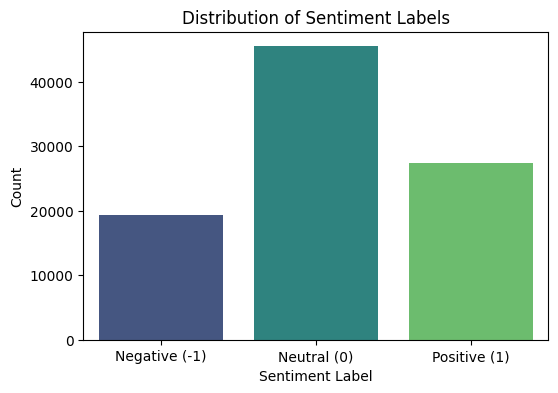

In [ ]:


plt.figure(figsize=(6,4))

sns.countplot(x='gold_label', data=data, palette='viridis')

plt.title('Distribution of Sentiment Labels')

plt.xlabel('Sentiment Label')

plt.ylabel('Count')

plt.xticks(ticks=[0,1,2], labels=['Negative (-1)', 'Neutral (0)', 'Positive (1)'])

plt.show()


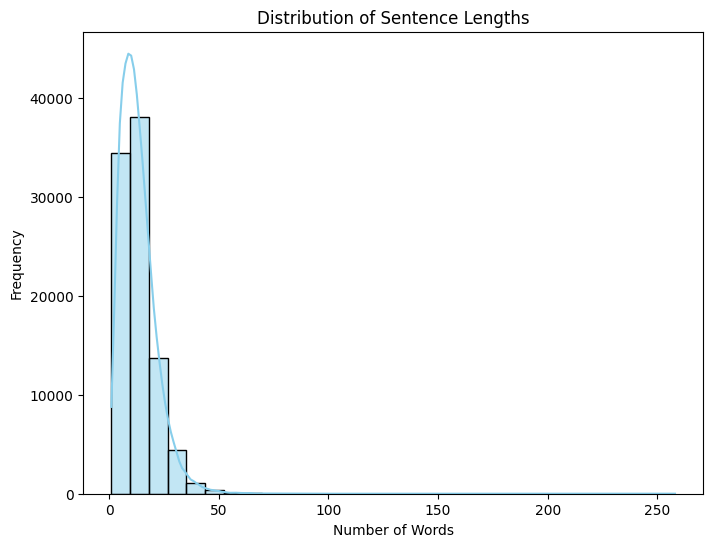

In [ ]:
# Calculating the sentence lengths

data['sentence_length'] = data['sentence'].apply(lambda x: len(x.split()))



# Plotting histogram of sentence lengths

plt.figure(figsize=(8,6))

sns.histplot(data['sentence_length'], bins=30, kde=True, color='skyblue')

plt.title('Distribution of Sentence Lengths')

plt.xlabel('Number of Words')

plt.ylabel('Frequency')

plt.show()


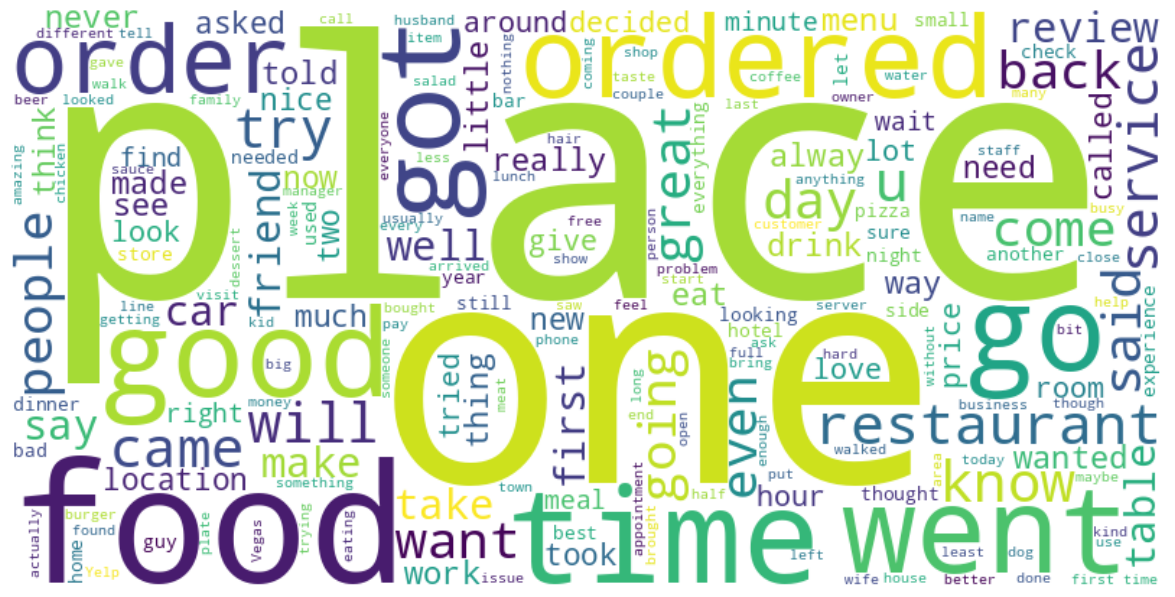

In [ ]:
from wordcloud import WordCloud





text = ' '.join(data['sentence'])



# Generating word cloud helps us to visualise most common words in the data excluding stop words

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)



plt.figure(figsize=(15, 7.5))

plt.imshow(wordcloud, interpolation='bilinear')

plt.axis('off')

plt.show()


In [36]:
import numpy as np

import re

import nltk

from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder

from torch.utils.data import Dataset, DataLoader

import torch






In [ ]:
def clean_text(text):

    # Lowercasing the sentences

    text = text.lower()

    # Removing the URLs

    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Removing the user @ references and '#' from hashtags

    text = re.sub(r'\@\w+|\#','', text)

    # Removing punctuation and numbers

    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Removing extra spaces

    text = re.sub(r'\s+', ' ', text).strip()

    return text


In [ ]:
data['cleaned_sentence'] = data['sentence'].apply(clean_text)
# applying the clean function on the given dataset
dev_data['cleaned_sentence'] = dev_data['sentence'].apply(clean_text)



In [ ]:
nltk.download('stopwords')

nltk.download('punkt_tab')

stop_words = set(stopwords.words('english'))



def tokenize(text):

    tokens = nltk.word_tokenize(text)

    tokens = [word for word in tokens if word not in stop_words]

    return tokens



data['tokens'] = data['cleaned_sentence'].apply(tokenize)

# Tokenizing and removing stopwords using nltk
# dev_data['tokens'] = dev_data['cleaned_sentence'].apply(tokenize)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:


label_mapping = {

    -1: 0,

    0: 1,

    1: 2

}


#  I have converted the labels from -1,0,1 to 0,1,2 for better label prediction

data['encoded_label'] = data['gold_label'].map(label_mapping)



print(data[['gold_label', 'encoded_label']].head())


   gold_label  encoded_label
0           0              1
1          -1              0
2           0              1
3           1              2
4           0              1


In [41]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, stratify=data['encoded_label'])



print(f"Training samples: {len(train_data)}")

print(f"Testing samples: {len(test_data)}")


Training samples: 73782
Testing samples: 18446


In [ ]:
from collections import defaultdict

# !wget http://nlp.stanford.edu/data/glove.6B.zip

# !unzip glove.6B.zip



# Building vocabulary

vocab = defaultdict(lambda: len(vocab))

vocab['<PAD>'] = 0

vocab['<UNK>'] = 1
# handling oov words



for tokens in train_data['tokens']:

    for token in tokens:

        vocab[token]



vocab_size = len(vocab)

print(f"Vocabulary Size: {vocab_size}")



# Loading the GloVe embeddings and taking the dimensions of the embeddings to be 100

embedding_dim = 100

embeddings_index = {}



with open('glove.6B.100d.txt', encoding='utf-8') as f:

    for line in f:

        values = line.split()

        word = values[0]

        vector = np.asarray(values[1:], dtype='float32')

        embeddings_index[word] = vector



print(f"Loaded {len(embeddings_index)} word vectors from GloVe.")



embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, idx in vocab.items():

    if word in embeddings_index:

        embedding_matrix[idx] = embeddings_index[word]

    else:

        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))



embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float)


Vocabulary Size: 29916
Loaded 400000 word vectors from GloVe.


In [43]:
class SentimentDataset(Dataset):

    def __init__(self, dataframe, vocab, max_len=100):

        self.data = dataframe

        self.vocab = vocab

        self.max_len = max_len



    def __len__(self):

        return len(self.data)



    def encode_sentence(self, tokens):

        encoded = [self.vocab.get(token, self.vocab['<UNK>']) for token in tokens]

        if len(encoded) < self.max_len:

            encoded += [self.vocab['<PAD>']] * (self.max_len - len(encoded))

        else:

            encoded = encoded[:self.max_len]

        return encoded



    def __getitem__(self, idx):

        tokens = self.data.iloc[idx]['tokens']

        encoded = self.encode_sentence(tokens)

        label = self.data.iloc[idx]['encoded_label']

        return torch.tensor(encoded, dtype=torch.long), torch.tensor(label, dtype=torch.long)


In [ ]:
#  because of the unbalanced nature of the data I have given weights to every 

from torch.utils.data import WeightedRandomSampler
from sklearn.utils.class_weight import compute_class_weight


# Computing class weights
classes = sorted(train_data['encoded_label'].unique())
classes=np.array(classes)
print(classes)
class_counts = train_data['encoded_label'].value_counts().sort_index().values
print(class_counts)
class_weights = compute_class_weight('balanced', classes=classes, y=train_data['encoded_label'])
print(class_weights)
class_weights = torch.tensor(class_weights, dtype=torch.float)

print(f"Class Weights: {class_weights}")

# Creating a weight for each sample
samples_weight = class_weights[train_data['encoded_label'].values]


# Creating a weight for each sample based on the sorted classes
samples_weight = class_weights[train_data['encoded_label'].values]
print(f"Sample Weight for First Instance: {samples_weight[81]}")  # Should correspond to class 0 or 1 or 2
print(f"Encoded Label of First Instance: {train_data['encoded_label'].values[81]}")


sampler = WeightedRandomSampler(weights=samples_weight, num_samples=len(samples_weight), replacement=True)

batch_size = 64
max_len = 100

train_dataset = SentimentDataset(train_data, vocab, max_len)
test_dataset = SentimentDataset(test_data, vocab, max_len)

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

dev_dataset = SentimentDataset(dev_data, vocab, max_len)

dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)

[0 1 2]
[15509 36391 21882]
[1.5857889  0.67582644 1.12393748]
Class Weights: tensor([1.5858, 0.6758, 1.1239])
Sample Weight for First Instance: 1.5857888460159302
Encoded Label of First Instance: 0


In [45]:
import torch.nn as nn

import torch.optim as optim


In [ ]:
class Attention(nn.Module):

    def __init__(self, hidden_dim):

        super(Attention, self).__init__()

        self.attention = nn.Linear(hidden_dim * 2, hidden_dim * 2)

        self.context_vector = nn.Linear(hidden_dim * 2, 1, bias=False)



    def forward(self, lstm_output):

        # lstm_output: [batch_size, seq_len, hidden_dim * 2]

        scores = torch.tanh(self.attention(lstm_output))  # [batch_size, seq_len, hidden_dim * 2]

        scores = self.context_vector(scores).squeeze(-1)  # [batch_size, seq_len]

        attn_weights = torch.softmax(scores, dim=1).unsqueeze(-1)  # [batch_size, seq_len, 1]

        context = lstm_output * attn_weights  # [batch_size, seq_len, hidden_dim * 2]

        context = torch.sum(context, dim=1)  # [batch_size, hidden_dim * 2]

        return context


In [47]:
class BiLSTMAttention(nn.Module):

    def __init__(self, embedding_matrix, hidden_dim, output_dim, n_layers,

                 bidirectional, dropout, pad_idx):

        super(BiLSTMAttention, self).__init__()

        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False, padding_idx=pad_idx)

        self.lstm = nn.LSTM(embedding_matrix.size(1),

                            hidden_dim,

                            num_layers=n_layers,

                            bidirectional=bidirectional,

                            batch_first=True,

                            dropout=dropout if n_layers > 1 else 0)

        self.attention = Attention(hidden_dim)

        self.fc = nn.Linear(hidden_dim * 2, output_dim)

        self.dropout = nn.Dropout(dropout)



    def forward(self, text):

        # text: [batch_size, seq_len]

        embedded = self.embedding(text)  # [batch_size, seq_len, embedding_dim]

        embedded = self.dropout(embedded)

        lstm_out, _ = self.lstm(embedded)  # [batch_size, seq_len, hidden_dim * 2]

        attn_output = self.attention(lstm_out)  # [batch_size, hidden_dim * 2]

        attn_output = self.dropout(attn_output)

        output = self.fc(attn_output)  # [batch_size, output_dim]

        return output


In [ ]:
# Model parameters

hidden_dim = 128

output_dim = 3  # Three classes: Negative, Neutral, Positive

n_layers = 3

bidirectional = True

dropout = 0.6

pad_idx = vocab['<PAD>']



model = BiLSTMAttention(embedding_matrix=embedding_matrix,

                        hidden_dim=hidden_dim,

                        output_dim=output_dim,

                        n_layers=n_layers,

                        bidirectional=bidirectional,

                        dropout=dropout,

                        pad_idx=pad_idx)



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)


In [59]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-3)



criterion = criterion.to(device)


In [ ]:
def categorical_accuracy(preds, y):


    _, predicted = torch.max(preds, 1)

    correct = (predicted == y).float()

    acc = correct.sum() / len(correct)

    return acc


In [61]:
def train(model, loader, optimizer, criterion):

    model.train()

    epoch_loss = 0

    epoch_acc = 0



    for texts, labels in loader:

        texts = texts.to(device)

        labels = labels.to(device)



        optimizer.zero_grad()

        predictions = model(texts)



        loss = criterion(predictions, labels)

        acc = categorical_accuracy(predictions, labels)



        loss.backward()

        optimizer.step()



        epoch_loss += loss.item()

        epoch_acc += acc.item()



    return epoch_loss / len(loader), epoch_acc / len(loader)



def evaluate(model, loader, criterion):

    model.eval()

    epoch_loss = 0

    epoch_acc = 0



    with torch.no_grad():

        for texts, labels in loader:

            texts = texts.to(device)

            labels = labels.to(device)



            predictions = model(texts)



            loss = criterion(predictions, labels)

            acc = categorical_accuracy(predictions, labels)



            epoch_loss += loss.item()

            epoch_acc += acc.item()



    return epoch_loss / len(loader), epoch_acc / len(loader)


In [62]:
import time



def epoch_time(start_time, end_time):

    elapsed_time = end_time - start_time

    return int(elapsed_time // 60), int(elapsed_time % 60)


In [ ]:
N_EPOCHS = 10

best_valid_loss = float('inf')

patience = 3

counter = 0



for epoch in range(N_EPOCHS):

    start_time = time.time()



    train_loss, train_acc = train(model, train_loader, optimizer, criterion)

    valid_loss, valid_acc = evaluate(model, test_loader, criterion)



    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)




    if valid_loss < best_valid_loss:

        best_valid_loss = valid_loss

        torch.save(model.state_dict(), 'sentiment.pt')

        counter = 0

    else:

        counter += 1



    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')

    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')

    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')



    if counter >= patience:

        print("Early stopping triggered.")

        break


Epoch: 01 | Time: 0m 47s
	Train Loss: 0.949 | Train Acc: 54.25%
	 Val. Loss: 0.830 |  Val. Acc: 65.85%
Epoch: 02 | Time: 0m 41s
	Train Loss: 0.848 | Train Acc: 62.34%
	 Val. Loss: 0.823 |  Val. Acc: 64.71%
Epoch: 03 | Time: 0m 42s
	Train Loss: 0.806 | Train Acc: 64.77%
	 Val. Loss: 0.775 |  Val. Acc: 67.25%
Epoch: 04 | Time: 0m 41s
	Train Loss: 0.765 | Train Acc: 66.94%
	 Val. Loss: 0.795 |  Val. Acc: 66.76%
Epoch: 05 | Time: 0m 44s
	Train Loss: 0.744 | Train Acc: 68.01%
	 Val. Loss: 0.780 |  Val. Acc: 67.61%
Epoch: 06 | Time: 0m 43s
	Train Loss: 0.716 | Train Acc: 69.54%
	 Val. Loss: 0.778 |  Val. Acc: 68.10%
Early stopping triggered.


In [ ]:
# Load the best model
model.load_state_dict(torch.load('sentiment.pt'))

test_loss, test_acc = evaluate(model, test_loader, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')


<ipython-input-64-06739fb70b2c>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('sentiment_0.63_val.pt'))


Test Loss: 0.775 | Test Acc: 67.25%


In [65]:
from sklearn.metrics import classification_report

def get_predictions(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for texts, labels in loader:
            texts = texts.to(device)
            labels = labels.to(device)
            outputs = model(texts)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds

labels, preds = get_predictions(model, test_loader)
print(labels[:5])
print(classification_report(labels, preds, target_names=['Negative', 'Neutral', 'Positive']))

# print(dev_predictions[:5])

[1, 2, 1, 1, 1]
              precision    recall  f1-score   support

    Negative       0.53      0.59      0.56      3877
     Neutral       0.75      0.74      0.74      9098
    Positive       0.66      0.62      0.64      5471

    accuracy                           0.67     18446
   macro avg       0.65      0.65      0.65     18446
weighted avg       0.68      0.67      0.67     18446



In [ ]:
inverse_label_mapping = {
    0: -1,  # Negative
    1: 0,   # Neutral
    2: 1    # Positive
}
def predict_sentiment(sentence, model, vocab, max_len=100):
    
    # Preprocessing the sentence
    cleaned = clean_text(sentence)
    tokens = tokenize(cleaned)

    # Encoding the sentence
    encoded = [vocab.get(token, vocab['<UNK>']) for token in tokens]

    if len(encoded) < max_len:
        encoded += [vocab['<PAD>']] * (max_len - len(encoded))
    else:
        encoded = encoded[:max_len]

    input_tensor = torch.tensor(encoded, dtype=torch.long).unsqueeze(0)  # Shape: [1, max_len]
    input_tensor = input_tensor.to(device)

    with torch.no_grad():
        output = model(input_tensor)  # Shape: [1, output_dim]
        _, pred = torch.max(output, 1)  # Shape: [1]
        pred = pred.item()

    label = inverse_label_mapping.get(pred, 0)  # Default to 0 if not found

    return label


In [67]:
dev_data['sentence'][19]

'We were in Vegas for 11 days and I needed a bunch of this and that, so off to CVS we went. It was awesome.'

In [ ]:
# Example sentences
sentences = dev_data['sentence']
ans=[]
# Predicting sentiments of this example sentence
for idx, sentence in enumerate(sentences, 1):
    predictions = predict_sentiment(sentence, model, vocab, max_len=100)
    ans.append(predictions)
    # ans.append(label)
print(ans[:20])

[1, 0, 0, 0, -1, -1, 0, 1, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 1]


In [ ]:
output_file = 'predictions_1.csv'
import csv

with open(output_file, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
   
    for label in ans:
        writer.writerow([label])
# output_file = output_file.iloc[:-1]
print(f"Labels have been written to {output_file}")

Labels have been written to predictions_1.csv


In [ ]:
import csv

input_csv = 'predictions_1.csv'
# df=pd.read_csv(input_csv)
output_txt = 'pred_1.txt'
# df = df.iloc[:-1]
# df.to_csv(input_csv, index=False)

with open(input_csv, 'r', newline='', encoding='utf-8') as csvfile, \
     open(output_txt, 'w', encoding='utf-8') as txtfile:

    reader = csv.reader(csvfile)
    for row in reader:
        
        line = ' '.join(row)
        txtfile.write(line + '\n')

print(f"Converted {input_csv} to {output_txt} successfully.")


Converted predictions_1.csv to pred_1.txt successfully.
